In [1]:

import tensorflow as tf
from tensorflow.keras.layers import LSTMCell
tf.compat.v1.disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [2]:
data = pd.read_csv('IKNA.csv')
data.head()

,ticker,date,open,high,low,close
0,IKNA,2021-03-26,22.40,37.61,19.0101,32.00
1,IKNA,2021-03-29,28.25,33.69,24.5200,28.30
2,IKNA,2021-03-30,28.80,30.24,23.8100,25.60
3,IKNA,2021-03-31,25.01,28.68,24.3801,28.25
4,IKNA,2021-04-01,27.01,27.01,23.1800,26.00


In [3]:
df=data.copy()

In [4]:
df.drop(['ticker'],axis=1)

,date,open,high,low,close
0,2021-03-26,22.40,37.6100,19.0101,32.000
1,2021-03-29,28.25,33.6900,24.5200,28.300
2,2021-03-30,28.80,30.2400,23.8100,25.600
3,2021-03-31,25.01,28.6800,24.3801,28.250
4,2021-04-01,27.01,27.0100,23.1800,26.000
...,...,...,...,...,...
829,2024-07-15,1.74,1.7794,1.6900,1.700
830,2024-07-16,1.73,1.7700,1.7250,1.725
831,2024-07-17,1.68,1.7100,1.6800,1.710
832,2024-07-18,1.69,1.7200,1.6800,1.690


In [5]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.765536
1,1.000000
2,0.969787
3,0.994047
4,0.942979


In [6]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((834, 6), (804, 1), (30, 1))

In [7]:
import tensorflow as tf
from tensorflow import keras
tf.compat.v1.disable_eager_execution()

In [8]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.compat.v1.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.compat.v1.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    mse = np.mean(np.square(real - predict))
    return mse

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [9]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [10]:
def forecast():
    tf.compat.v1.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 1]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [11]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
2024-07-21 00:00:52.670346: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
train loop: 100%|█| 300/300 [01:02<00:00,  4.79it/s, acc=0.000826, cost=0.000826

simulation 2



/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/Users/shikarichacha/anaconda3/lib/python3.11/site-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session

simulation 3



/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/Users/shikarichacha/anaconda3/lib/python3.11/site-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session

simulation 4


/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/Users/shikarichacha/anaconda3/lib/python3.11/site-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session 

simulation 5



/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/Users/shikarichacha/anaconda3/lib/python3.11/site-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session

simulation 6



/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/Users/shikarichacha/anaconda3/lib/python3.11/site-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session

simulation 7



/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/Users/shikarichacha/anaconda3/lib/python3.11/site-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session

simulation 8



/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/Users/shikarichacha/anaconda3/lib/python3.11/site-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session

simulation 9



/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/Users/shikarichacha/anaconda3/lib/python3.11/site-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session

simulation 10



/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:12: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
/var/folders/qh/215l544s06x3_jp987f9gdgh0000gn/T/ipykernel_13667/3070950353.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits =  tf.compat.v1.layers.dense(self.outputs[-1], output_size)
/Users/shikarichacha/anaconda3/lib/python3.11/site-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session

In [12]:
df = data.copy()
df.drop(['ticker'], axis=1, inplace=True)

# Calculate returns instead of prices
df_returns = df['close'].pct_change().fillna(0)


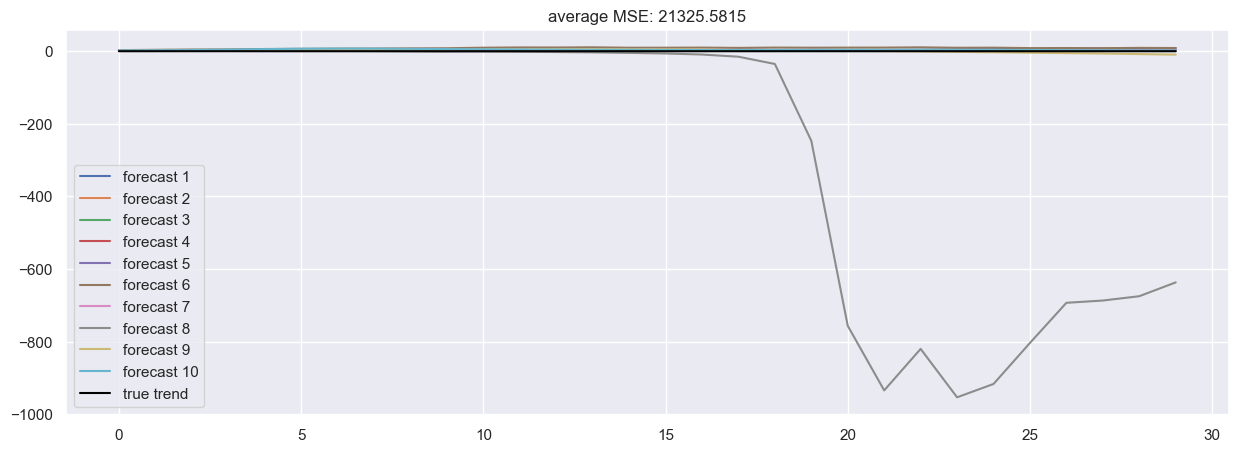

In [13]:
mse_scores = [calculate_accuracy(df_returns.iloc[-test_size:].values, r) for r in results]

plt.figure(figsize=(15, 5))
for no, r in enumerate(results[:]):
    plt.plot(r, label='forecast %d' % (no + 1))
plt.plot(df_returns.iloc[-test_size:].values, label='true trend', c='black')
plt.legend()
plt.title('average MSE: %.4f' % (np.mean(mse_scores)))
plt.show()

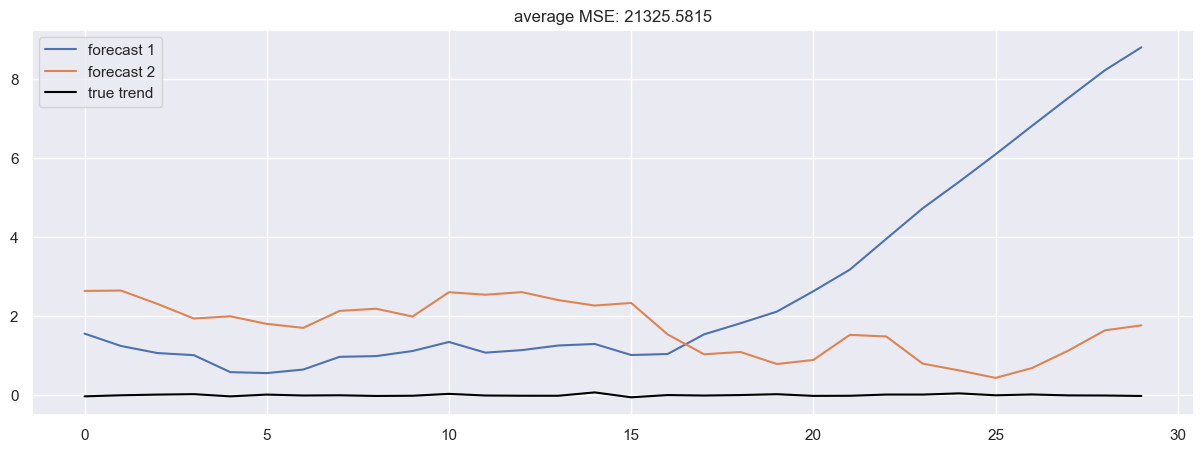

In [14]:
mse_scores = [calculate_accuracy(df_returns.iloc[-test_size:].values, r) for r in results]

plt.figure(figsize=(15, 5))
for no, r in enumerate(results[:2]):
    plt.plot(r, label='forecast %d' % (no + 1))
plt.plot(df_returns.iloc[-test_size:].values, label='true trend', c='black')
plt.legend()
plt.title('average MSE: %.4f' % (np.mean(mse_scores)))
plt.show()


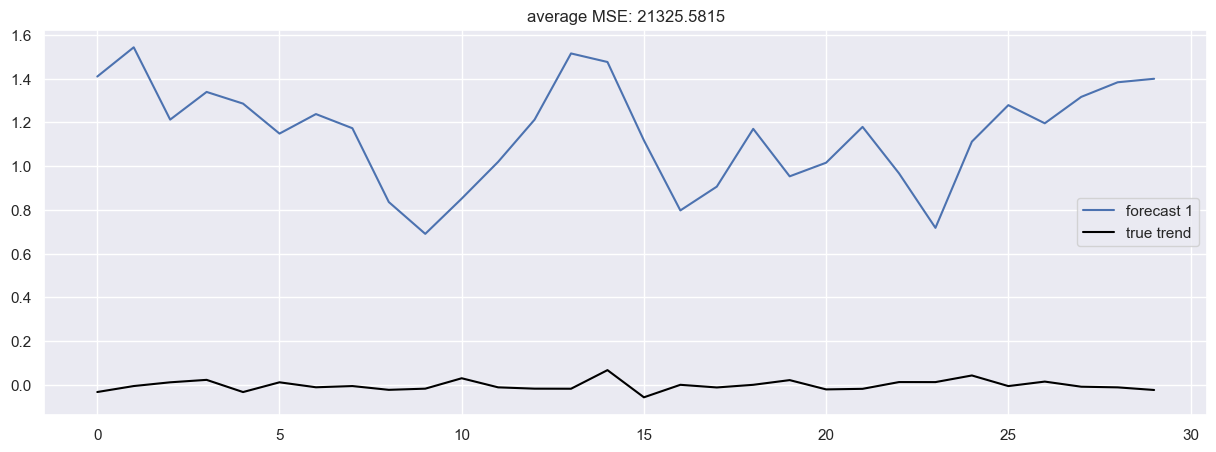

In [15]:
mse_scores = [calculate_accuracy(df_returns.iloc[-test_size:].values, r) for r in results]

plt.figure(figsize=(15, 5))
for no, r in enumerate(results[2:3]):
    plt.plot(r, label='forecast %d' % (no + 1))
plt.plot(df_returns.iloc[-test_size:].values, label='true trend', c='black')
plt.legend()
plt.title('average MSE: %.4f' % (np.mean(mse_scores)))
plt.show()


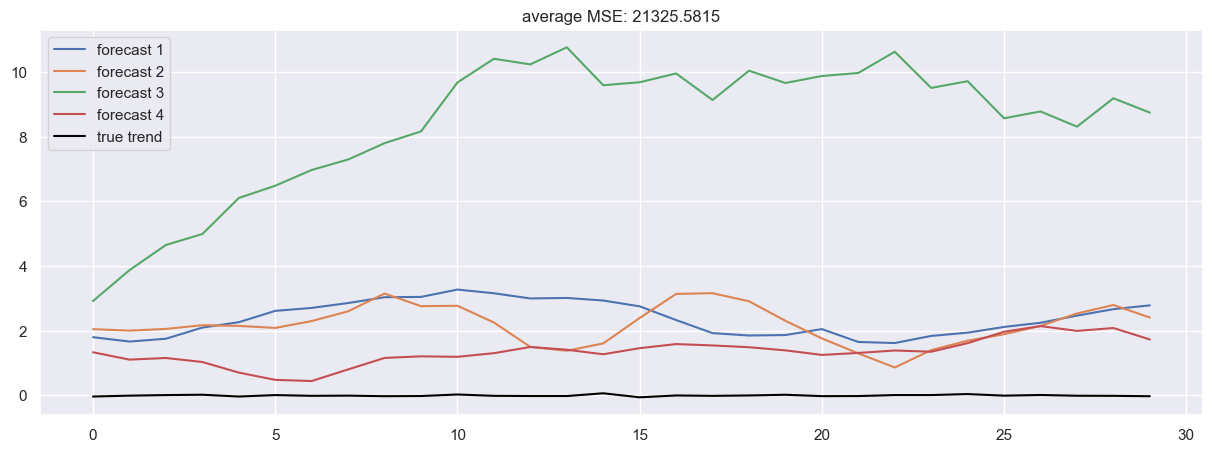

In [16]:
mse_scores = [calculate_accuracy(df_returns.iloc[-test_size:].values, r) for r in results]

plt.figure(figsize=(15, 5))
for no, r in enumerate(results[3:7]):
    plt.plot(r, label='forecast %d' % (no + 1))
plt.plot(df_returns.iloc[-test_size:].values, label='true trend', c='black')
plt.legend()
plt.title('average MSE: %.4f' % (np.mean(mse_scores)))
plt.show()



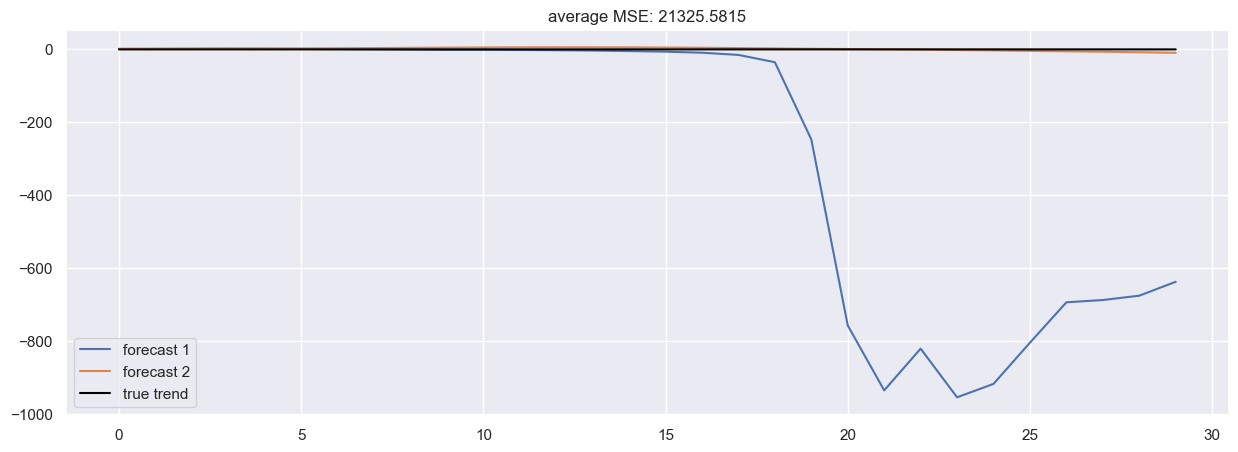

In [17]:
mse_scores = [calculate_accuracy(df_returns.iloc[-test_size:].values, r) for r in results]

plt.figure(figsize=(15, 5))
for no, r in enumerate(results[7:9]):
    plt.plot(r, label='forecast %d' % (no + 1))
plt.plot(df_returns.iloc[-test_size:].values, label='true trend', c='black')
plt.legend()
plt.title('average MSE: %.4f' % (np.mean(mse_scores)))
plt.show()

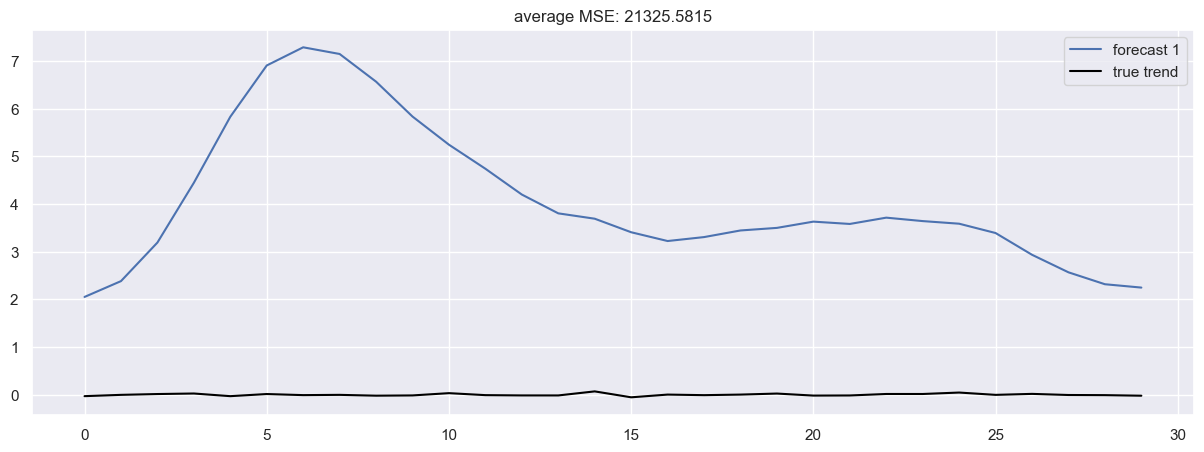

In [18]:
mse_scores = [calculate_accuracy(df_returns.iloc[-test_size:].values, r) for r in results]

plt.figure(figsize=(15, 5))
for no, r in enumerate(results[9:]):
    plt.plot(r, label='forecast %d' % (no + 1))
plt.plot(df_returns.iloc[-test_size:].values, label='true trend', c='black')
plt.legend()
plt.title('average MSE: %.4f' % (np.mean(mse_scores)))
plt.show()